In [1]:
from pathlib import Path
from time import time
from functools import partial
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ot import sinkhorn
from scipy.spatial.distance import cdist
cdist = partial(cdist, metric="sqeuclidean")

from estimate_ot import ContinuousDistribution, FiniteDistribution
import clustering

sns.set_style('whitegrid')

# DOT

In [3]:
save_dir = Path('data/DOT/Data')
assert save_dir.is_dir()

possible_types = list(map(lambda x: x.name, save_dir.iterdir()))
print(f'possible types: {possible_types}')

def image_to_distribution(image_path: Path, n_samples: int = -1):
    assert image_path.is_file()
    image = np.loadtxt(image_path, delimiter=',')
    n, m = image.shape
    
    coordinates = np.stack([np.arange(n)[:, np.newaxis] * np.ones(n), 
                            np.arange(m) * np.ones(m)[:, np.newaxis]]
                          ).transpose().reshape(-1, 2)
    weights = image.flatten()
    weights = weights / np.sum(weights)
    
    if n_samples > 0:
        assert n_samples < n * m
        idx = np.random.choice(n*m, size=n_samples, replace=False)
    else:
        idx = np.arange(n*m)
    
    return FiniteDistribution(coordinates[idx], weights[idx]/weights[idx].sum(), replace=False)

possible types: ['CauchyDensity', 'GRFsmooth', 'MicroscopyImages', 'GRFmoderate', 'GRFrough', 'ClassicImages']


In [4]:
config_xp = {
    'resolution': 64,
    'type_image': 'MicroscopyImages',
}

list_of_images = list((save_dir / config_xp['type_image']).glob(f'data{config_xp["resolution"]}_*.csv'))

list_of_images

[PosixPath('data/DOT/Data/MicroscopyImages/data64_1006.csv'),
 PosixPath('data/DOT/Data/MicroscopyImages/data64_1009.csv'),
 PosixPath('data/DOT/Data/MicroscopyImages/data64_1004.csv'),
 PosixPath('data/DOT/Data/MicroscopyImages/data64_1010.csv'),
 PosixPath('data/DOT/Data/MicroscopyImages/data64_1002.csv'),
 PosixPath('data/DOT/Data/MicroscopyImages/data64_1003.csv'),
 PosixPath('data/DOT/Data/MicroscopyImages/data64_1008.csv'),
 PosixPath('data/DOT/Data/MicroscopyImages/data64_1007.csv'),
 PosixPath('data/DOT/Data/MicroscopyImages/data64_1001.csv'),
 PosixPath('data/DOT/Data/MicroscopyImages/data64_1005.csv')]

In [7]:
index = pd.MultiIndex.from_tuples(
    [],
    names=["method", "j", "k", "eps"])
columns = ["t_tot", "OT", "rel_error", "error_msg"]
df = pd.DataFrame(index=index, columns=columns).astype('float32')

config_xp = {
    'n_points': 100,
    'n_max_eps': 6,
    'init_eps': 2**9,
    'n_iter_max': 10000,
    'n_iter_max_centroids': 9 * 10000,
}

In [ ]:
print('starting...')

i = 0
stop = False
for eps in range(config_xp['n_max_eps']):
    if stop: break
    t1 = time()
    eps = config_xp['init_eps'] * 1.8 ** (-i)
    print(f'Run i: {i}. Doing eps: {eps:.1e}', end=' ')
    for run, (j, k) in enumerate(itertools.combinations(range(10), 2)):
        # Set distributions
        alpha = image_to_distribution(list_of_images[j], n_samples=config_xp['n_points'])
        beta = image_to_distribution(list_of_images[k], n_samples=config_xp['n_points'])
        true_ot_cost = alpha.emd(beta).transport_cost
        
        # Full
        t_tot = time()
        result_full = clustering.entropic_wasserstein_sin(
            alpha.support, beta.support, eps, config_xp['n_iter_max'])
        t_tot = time() - t_tot
        print(f'([FULL {run}/{45}] in {t_tot:.2}s)', end=' ')

        if result_full.error_msg != 0:
            print(f'[FULL] Got error_msg {result_full.error_msg} at i={i}, run={run}')
            stop = True
        df.loc[('full', j, k, eps), :] = [t_tot, 
                                       result_full.transport_cost, 
                                       np.abs(result_full.transport_cost**.5 - true_ot_cost**.5),
                                       result_full.error_msg]

        # KMeans
        t_tot = time()
        result_centroids = clustering.entropic_wasserstein_kmeans_sin(
            alpha.support, beta.support, alpha.weights, beta.weights, 
            eps, 
            config_xp['n_iter_max_centroids'])
        t_tot = time() - t_tot

        if result_centroids.error_msg != 0:
            print(f'[CENTROID] Got error_msg {result_centroids.error_msg} at i={i}.')

        df.loc[('kmeans', j, k, eps), :] = [t_tot,
                                            result_centroids.transport_cost,
                                            np.abs(result_centroids.transport_cost**.5 - true_ot_cost**.5),
                                            result_centroids.error_msg]
    print(f'(total={time()-t1:.1f}s)')
    i += 1
    df.to_csv('data/DOT/save.csv')


df = df.reset_index()

<IPython.core.display.Javascript object>


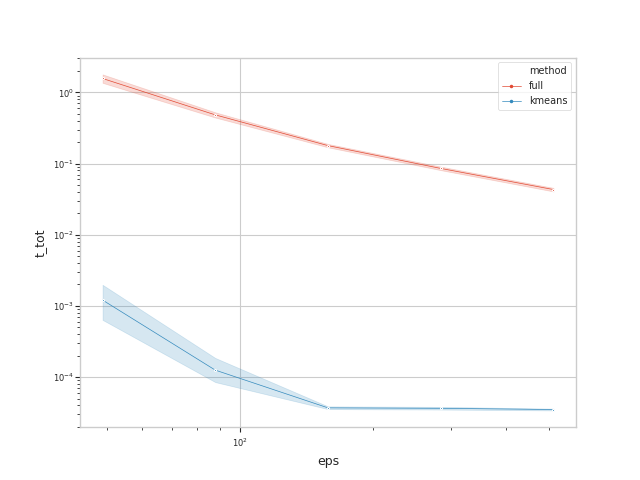

In [10]:
sns.lineplot('eps', 't_tot', hue='method', data=df)
plt.xscale('log')
plt.yscale('log')

# Gaussian with c++ Sinkhorn's solver

$n$ points sampled from gaussian centered in 0 or 1. 

In [4]:
dim = 3
n_points = 10
n_iter_max = 1000

Test:

In [5]:
std = 1e-1
cov = std * np.eye(dim)
alpha = ContinuousDistribution.gaussian(np.zeros(dim), cov).to_discrete(n_points)
beta = ContinuousDistribution.gaussian(np.ones(dim), cov).to_discrete(n_points)

Unregularized cost: 

In [6]:
from ot import emd, sinkhorn

In [7]:
result_unregularized = alpha.emd(beta)
print(f'Unregularized cost: {result_unregularized.transport_cost:.3e}.')
with np.printoptions(precision=3, suppress=True):
    print(f'Transport plan:\n{result_unregularized.transport_plan}')

Unregularized cost: 3.478e+00.
Transport plan:
[[0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0. ]
 [0.  0.  0.1 0.  0.  0.  0.  0.  0.  0. ]]


In [8]:
cost_matrix = cdist(alpha.support, beta.support)
eps = 1e-6
eta = .1

result_sinkhorn = clustering.sinkhorn(cost_matrix, alpha.weights, beta.weights, 
                                      eps=eps, eta=eta,
                                      u=np.zeros(alpha.n_samples), v=np.zeros(beta.n_samples))
print(f'Regularized cost: {result_sinkhorn.transport_cost:.3e}.')
print(f'Duality gap: {result_sinkhorn.duality_gap:.3e}.')
print(f'Constraint violation: {result_sinkhorn.errors[-1]:.3e}.')
with np.printoptions(precision=2, suppress=True):
    print(f'Transport plan:\n{result_sinkhorn.transport_plan}')

Regularized cost: 3.526e+00.
Duality gap: 3.526e+00.
Constraint violation: 9.760e-07.
Transport plan:
[[0.01 0.02 0.   0.   0.   0.01 0.02 0.02 0.01 0.02]
 [0.01 0.01 0.01 0.   0.   0.   0.02 0.   0.   0.04]
 [0.01 0.03 0.   0.   0.02 0.   0.   0.03 0.01 0.  ]
 [0.01 0.01 0.01 0.   0.   0.01 0.02 0.   0.01 0.03]
 [0.06 0.   0.   0.04 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.05 0.01 0.   0.   0.04 0.   0.  ]
 [0.   0.   0.   0.   0.06 0.   0.01 0.   0.03 0.  ]
 [0.   0.   0.   0.01 0.   0.08 0.   0.   0.   0.01]
 [0.   0.01 0.02 0.   0.01 0.   0.02 0.   0.04 0.  ]
 [0.01 0.02 0.05 0.   0.   0.   0.   0.   0.01 0.  ]]


In [9]:
result_sinkhorn_pot = sinkhorn(alpha.weights, beta.weights, cost_matrix, reg=eta, method='sinkhorn_stabilized', stopThr=eps)
print(f'Regularized cost: {(result_sinkhorn_pot*cost_matrix).sum():.3e}.')
with np.printoptions(precision=2, suppress=True):
    print(result_sinkhorn_pot)

Regularized cost: 3.526e+00.
[[0.01 0.02 0.   0.   0.   0.01 0.02 0.02 0.01 0.02]
 [0.01 0.01 0.01 0.   0.   0.   0.02 0.   0.   0.04]
 [0.01 0.03 0.   0.   0.02 0.   0.   0.03 0.01 0.  ]
 [0.01 0.01 0.01 0.   0.   0.01 0.02 0.   0.01 0.03]
 [0.06 0.   0.   0.04 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.05 0.01 0.   0.   0.04 0.   0.  ]
 [0.   0.   0.   0.   0.06 0.   0.01 0.   0.03 0.  ]
 [0.   0.   0.   0.01 0.   0.08 0.   0.   0.   0.01]
 [0.   0.01 0.02 0.   0.01 0.   0.02 0.   0.04 0.  ]
 [0.01 0.02 0.05 0.   0.   0.   0.   0.   0.01 0.  ]]


In [10]:
%%timeit
assignment = clustering.kmeanspp(alpha.support, alpha.n_samples, 1e-3)

59.4 µs ± 1.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Configurations to test:

In [38]:
index = pd.MultiIndex.from_tuples(
    [],
    names=["method", "id", "eps", "std"])
columns = ["t_tot", "OT", "rel_error", "error_msg"]
df = pd.DataFrame(index=index, columns=columns).astype('float32')

config_xp = {
    'dim': 3,
    'n_points': 100,
    'std': [1e-3], #np.logspace(-5, -1, 3),
    'n_max_eps': 10,
    'n_runs': 50,
    'n_iter_max': 1000,
    'n_iter_max_centroids': 9 * 1000,
}

In [39]:
print('starting...')

for std in config_xp['std']:
    # Set the variance of the gaussian
    cov = std * np.eye(config_xp['dim'])
    alpha = ContinuousDistribution.gaussian(np.zeros(config_xp['dim']), cov).to_discrete(config_xp['n_points'])
    beta = ContinuousDistribution.gaussian(np.ones(config_xp['dim']), cov).to_discrete(config_xp['n_points'])
    true_ot = alpha.emd(beta)
    true_ot_cost = true_ot.transport_cost
    print(f"Unregularized OT cost is: {true_ot.transport_cost:.3e}")
    
    i = 0
    stop = False
    while (not stop) and (i < config_xp['n_max_eps']):
        t1 = time()
        eps = true_ot.transport_cost * 1.5 ** (-i-5)
        print(f'Run i: {i}. Doing eps: {eps:.1e}', end=' ')
        
        # Full
        t_tot = time()
        result_full = clustering.entropic_wasserstein_sin(alpha.support, beta.support, eps, config_xp['n_iter_max'])
        t_tot = time() - t_tot
        print(f'([FULL] in {t_tot:.1}s)')

        if result_full.error_msg != 0:
            print(f'[ALL] Got error_msg {result_full.error_msg} at i={i}, run={run}')
            stop = True
            break
        df.loc[('full', 0, eps, std), :] = [t_tot, 
                                              result_full.transport_cost, 
                                              np.abs(result_full.transport_cost**.5 - true_ot_cost**.5),
                                              result_full.error_msg]
        
        for run in range(config_xp['n_runs']):
            t_run = time()

            # KMeans
            t_tot = time()
            result_centroids = clustering.entropic_wasserstein_kmeans_sin(
                alpha.support, beta.support, alpha.weights, beta.weights, eps, config_xp['n_iter_max_centroids'])
            t_tot = time() - t_tot

            if result_centroids.error_msg != 0:
                print(f'[CENTROID] Got error_msg {result_centroids.error_msg} at i={i}, run={run}')

            df.loc[('kmeans', run, eps, std), :] = [t_tot,
                                                    result_centroids.transport_cost,
                                                    np.abs(result_centroids.transport_cost**.5 - true_ot_cost**.5),
                                                    result_centroids.error_msg]
            print(f'({time()-t_run:.1f}s)', end=' ')

        print(f'(total={time()-t1:.1f}s)')
        i += 1

        
df = df.reset_index()

starting...
Unregularized OT cost is: 3.010e+00
Run i: 0. Doing eps: 4.0e-01 ([FULL] in 0.002s)
(0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (total=0.2s)
Run i: 1. Doing eps: 2.6e-01 ([FULL] in 0.002s)
(0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) 

/home/gaspardb/miniconda3/envs/OT3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


(0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (total=0.2s)
Run i: 2. Doing eps: 1.8e-01 ([FULL] in 0.002s)
(0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (total=0.2s)
Run i: 3. Doing eps: 1.2e-01 ([FULL] in 0.002s)
(0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (total=0.2s)
Run i: 4. Doing eps: 7.8e-02 ([FULL] in 0.004s)
(0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s

<IPython.core.display.Javascript object>


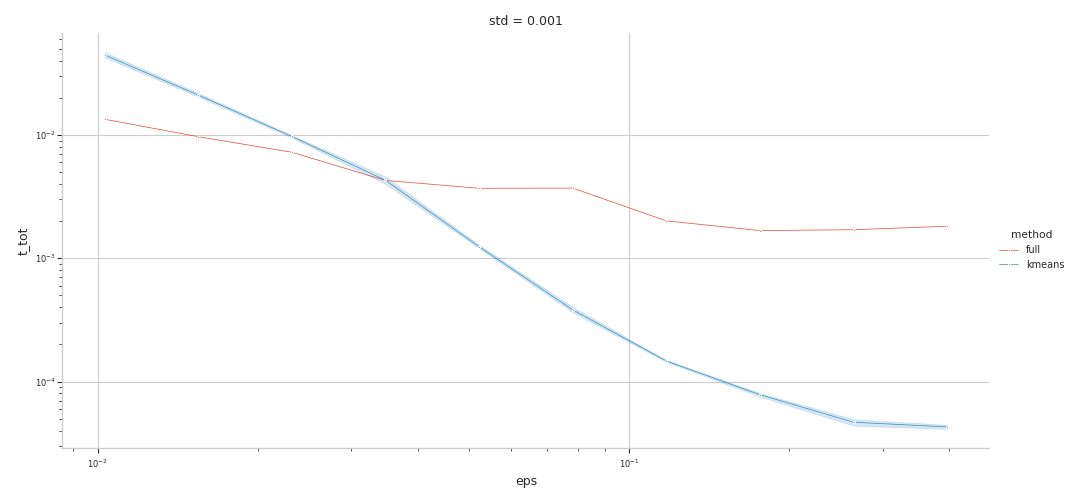

In [41]:
fg = sns.FacetGrid(df, 
                  row='std', hue='method', sharex=False, sharey=False,
                   height=5, aspect=2)
fg = fg.map(sns.lineplot, 'eps', 't_tot', )
fg.set(xscale='log')
fg.set(yscale='log')
fg.add_legend()

# Adult DS 

In [2]:
save_dir = Path('data/adult')

X = pd.read_csv(save_dir / "adult.data", usecols=(0, 2, 10, 11, 12, 14), names=['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours-per-week', 'target'])
X = X.iloc[:1000, :]  # EMD limit
X, y = X.iloc[:, :-1].astype('float64'), X.iloc[:, -1] == ' <=50K'
X = (X - X.mean(0)) / X.std(0)

dim = X.shape[1]

In [3]:
alpha = FiniteDistribution(X.values[y, :dim], replace=True)
beta = FiniteDistribution(X.values[~y, :dim], replace=True)

In [4]:
true_ot_cost = alpha.emd(beta, ).transport_cost

In [16]:
index = pd.MultiIndex.from_tuples(
    [],
    names=["method", "id", "eps"])
columns = ["t_tot", "OT", "rel_error", "error_msg"]
df = pd.DataFrame(index=index, columns=columns).astype('float32')

config_xp = {
    'dim': 3,
    'n_points': 100,
    'n_max_eps': 10,
    'n_runs': 50,
    'n_iter_max': 1000,
    'n_iter_max_centroids': 9 * 1000,
}

In [17]:
print('starting...')

i = 0
for i in range(config_xp['n_max_eps']):
    t1 = time()
    eps = true_ot_cost * 1.5 ** (-i+2)
    print(f'Run i: {i}. Doing eps: {eps:.1e}', end=' ')

    # Full
    t_tot = time()
    result_full = clustering.entropic_wasserstein_sin(alpha.support, beta.support, eps, config_xp['n_iter_max'])
    t_tot = time() - t_tot
    print(f'([FULL] in {t_tot:.1}s)')

    if result_full.error_msg != 0:
        print(f'[ALL] Got error_msg {result_full.error_msg} at i={i}, run={run}')
        stop = True
        break
    df.loc[('full', 0, eps), :] = [t_tot, 
                                          result_full.transport_cost, 
                                          np.abs(result_full.transport_cost**.5 - true_ot_cost**.5),
                                          result_full.error_msg]

    for run in range(config_xp['n_runs']):
        t_run = time()

        # KMeans
        t_tot = time()
        result_centroids = clustering.entropic_wasserstein_kmeans_sin(
            alpha.support, beta.support, alpha.weights, beta.weights, eps, config_xp['n_iter_max_centroids'])
        t_tot = time() - t_tot

        if result_centroids.error_msg != 0:
            print(f'[CENTROID] Got error_msg {result_centroids.error_msg} at i={i}, run={run}')

        df.loc[('kmeans', run, eps), :] = [t_tot,
                                                result_centroids.transport_cost,
                                                np.abs(result_centroids.transport_cost**.5 - true_ot_cost**.5),
                                                result_centroids.error_msg]
        print(f'({time()-t_run:.1f}s)', end=' ')

    print(f'(total={time()-t1:.1f}s)')
    i += 1


df = df.reset_index()

starting...
Run i: 0. Doing eps: 1.2e+01 ([FULL] in 0.8s)
(0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (total=1.0s)
Run i: 1. Doing eps: 8.1e+00 ([FULL] in 1e+00s)
(0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (total=1.4s)
Run i: 2. Doing eps: 5.4e+00 

/home/gaspardb/miniconda3/envs/OT3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


([FULL] in 2e+00s)
(0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (total=2.0s)
Run i: 3. Doing eps: 3.6e+00 ([FULL] in 3e+00s)
(0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (total=3.0s)
Run i: 4. Doing eps: 2.4e+00 ([FULL] in 5e+00s)
(0.1s) (0.1s) (0.1s) (0.1s) (0.1s) (0.0s) (0.0s) (0.1s) (0.1s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.0s) (0.2s) (0.0s) (0.0s) (0.1s) (0.1s) (0.1s) (0.1s) (0.0s

In [18]:
sns.lineplot(x='t_tot', y='rel_error', data=df, hue='method')